This is a notebook with code created by **Pedro Sánchez-Sánchez**, in collaboration with Freddy Monteiro. Pedro is currently (January 2024) a PhD student in the Quantitative Stem Cell Dynamics laboratory led by Alejo Rodríguez-Fraticelli (ICREA - IRB Barcelona). Freddy is manager of the Functional Genomics Core Facility (IRB Barcelona).

Below you can find the `R` code (computational efficiency could be improved) used in 4 functions created with the aim of **selecting the *n* most diverse pair of indexes** from a given `.csv` with 3 columns: name, sequence type A, sequence type B. We assume that the maximization of the total diversity per group of indexes tends to maximize the local diversity, i.e. the diversity of nucleotides in each position.

## Please navigate to Runtime -> Change runtime type and select R.

# Install packages

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.18")
BiocManager::install("Biostrings")
install.packages("reshape2")
install.packages("stringr")
install.packages("ggplot2")
install.packages("data.table")

# Create functions

The `mostdiverseindexes()` function takes a distance matrix (`distance_matrix`) between pairs of sequences, i.e indexes, of a common length (`len_seq`) and finds the less similar *n* indexes (`n_indexes`) for each index. The output is a list of matrices n x n and their diversity (total distance). Theoretically, the result should contain multiples entries with the same matrices and diversities except when multiple optimal solutions are possible. However, since it is not a perfect algorithm, the results may not be completely simmetric, i.e. the results for the indexes that create the optimal solution (if there is only one) may not be the same matrix.

In [19]:
mostdiverseindexes <- function(distance_matrix, len_seq, n_indexes) {
  # loop everything across the rows of the distance matrix
  #   created from the .csv (AKA wells in an plate of indexes)
  lapply(seq_len(nrow(distance_matrix)), function(well) {
    wells <- numeric()
    best_subset <- matrix(nrow = n_indexes, ncol = n_indexes)
    # loop from equal sequences to highest distance (because of being used as negative)
    # we substract 1 because in any case we want two similar sequences
    for (distance in 0:(len_seq - 1)) {
      # real loop stars by evaluating the most different sequences first
      wells <- which(distance_matrix[well, ] >= (len_seq - distance))
      # if the number of pairs of sequences is greater than the desired n_indexes (AKA *n*)
      # 'well' willl never be within 'wells' so we have to substract 1 to n_indexes
      # equal symbol is added to create the desired matrix if the desired *n* pairs are found
      if (length(wells) >= (n_indexes - 1)) {
        # start subseting the matrix
        subset <- distance_matrix[c(well, wells), c(well, wells)]
        # loop meanwhile the subset is greater than desired
        while (unique(dim(subset)) > n_indexes) {
          # remove the index with lowest distance to the others (sum by index)
          # one index per iteration to never create a matrix with less dimensions than desired
          remove <- which.min(apply(subset[-1, -1], 1, sum))
          # the 'remove[1]' is in case there are more than one with the lowest distance
          subset <- subset[- (remove[1] + 1), - (remove[1] + 1)]
          # when that is the case
          if (length(remove) > 1) {
            # loop for each well with the lowest distance
            for (well_combi in remove) {
              # when the sum of distances (AKA total diversity) is greater than removing '[1]'
              if (sum(subset[- (well_combi + 1), - (well_combi + 1)]) > sum(subset))
                # create proper subset
                # plus 1 because we guessed 'remove' without 'well'
                subset <- subset[- (well_combi + 1), - (well_combi + 1)]
            }
          }
        }
        # assign best_subset to allow the 'distance' loop to continue running
        #   and maybe finding other more optimal solution
        if (sum(subset) > sum(best_subset, na.rm = TRUE)) {
          best_subset <- subset
        } else if (sum(subset) == sum(best_subset, na.rm = TRUE)) {
          # warning when there is a similar best score
          warning(paste("\n", "Well ", well, ": similar best score of ", sum(subset), " distance;", "\n",
                        "involved wells are ",
                        paste(stringr::str_sort(rownames(subset), numeric = TRUE), collapse = ", "), sep = ""))
        }
      } else {
        # continue to the following 'distance' when a subset n x n is found
        next
      }
    }
    # output a list with a subset matrix of pair of indexes (n x n) and the total diversity of the subset
    # total diversity equals to the distance minus the length of the sequence
    list(best_subset, sum(best_subset))
  })

  # the loop ouputs a list with length equal to the number of rows of the input distance matrix
  #   i.e. a list with the best matrix n x n for each well
}

In [20]:
viewranking <- function(results_list, len_seq, n_indexes) {
  # order the wells according to the diversity (total distance)
  ranking <- order(unlist(lapply(results_list, function(well) well[[2]] )), decreasing = TRUE)
  # message what would be the theoretical maximum distance for that length of sequence
  message(paste("Maximum theoretical diversity is of",  (n_indexes - 1) * n_indexes * len_seq))
  # output the same list as mostdiverseindexes() but ordered by diversity
  results_list[ranking]
}

`getwells()` is prepared to work with names of wells such as A1, B10, D01, and each variations: aa-bb-A1, sample_0_well_A1, etc. However, a letter and a number cannot be together, e.g. sample0_A1. The user can modify this with the `structure` argument.

In [21]:
getwells <- function(results_list, len_seq, n_indexes,
                                 structure = "([:alpha:][:digit:][:digit:])|([:alpha:][:digit:])") {
  # loop on ranked results for creating a dataframe with two columns:
  #   the names, collapsed, of the indexes in each matrix and the diversity of the matrix (ratio)
  df <- data.table::rbindlist(lapply(
    viewranking(results_list, len_seq, n_indexes),
    function(well) {
      data.frame(wells = paste(stringr::str_sort(rownames(well[[1]]), numeric = TRUE), collapse = ", "),
                        diversity = well[[2]] / ((n_indexes - 1) * n_indexes * len_seq))
    }
  ))
  # loop for every position of the n x n matrix
  for (i in 1:n_indexes) {
    # add *n* columns with the name of that index to the previous dataframe
    df <- cbind(df, setNames(data.frame(
      stringr::str_extract(stringr::str_split(df$wells, ", ", simplify = TRUE)[, i],
                                    structure)), nm = paste("well", i, sep = "_")))
  }
  # output the data frame (ordered from high to low diversity)
  df
}

In [33]:
plotfrequencies <- function(selected_getwell, sequences, len_seq, pointsize = 5, n_seqs = 2) {
  # get names of the wells for the selected combinations of wells
  wells_names <- unlist(stringr::str_split(selected_getwell[1, ]$wells, ", "))
  # get nucleotides of the indexes
  df <- as.data.frame(t(stringr::str_split_fixed(as.character(sequences[wells_names]), "", len_seq)))
  colnames(df) <- wells_names
  # add the positional coordinate for each nucleotide
  df$position <- factor(rownames(df), levels = rownames(df))
  # melt the dataframe and compute the frequency of nucleotides per position
  df <- reshape2::melt(df, "position")
  df <- as.data.frame(table(df$position, df$value) / length(wells_names))
  # plot the frequency of nucleotides per position
  p1 <- ggplot2::ggplot(df, ggplot2::aes(x = Var1, y = Freq, color = Var2)) +
    ggplot2::geom_point(alpha = 0.25, size = pointsize) +
    ggplot2::theme_bw() + ggplot2::ylim(c(0, 1)) +
    ggplot2::xlab("Sequence position") + ggplot2::ylab("Frequency of nucleotides") +
    ggplot2::theme(legend.position = "top", legend.title = ggplot2::element_blank()) +
    ggplot2::ggtitle(paste(stringr::str_sort(wells_names, numeric = TRUE), collapse = ", "))
  if (n_seqs > 1) {
    p1 + ggplot2::geom_vline(xintercept = len_seq / n_seqs + 0.5, linetype = "dashed")
  } else {
    p1
  }
}

# Load `.csv`

After uploading the `.csv` file of interest in 'Files' (folder logo on the left), just load it with the code below.

In [13]:
indexes <- read.csv("/content/yourfileofinterest.csv")

In [23]:
head(indexes)

,index_name,index.i7.,index2_workflow_a.i5.
,<chr>,<chr>,<chr>
1,SI-TT-A1,GTAACATGCG,AGTGTTACCT
2,SI-TT-A2,GTGGATCAAA,GCCAACCCTG
3,SI-TT-A3,CACTACGAAA,TTAGACTGAT
4,SI-TT-A4,CTCTAGCGAG,TATCTTCATC
5,SI-TT-A5,GTAGCCCTGT,GAGCATCTAT
6,SI-TT-A6,TAACGCGTGA,CCCTAACTTC


# One sequence example

Create the distance matrix. In this case we compute the "hamming" distance for evaluating positional changes. Besides them, if you want insertions and deletions to be computed, compute the edit distance ("levenshtein").

In [25]:
nts <- unique(nchar(indexes$index.i7.))
seqA <- Biostrings::BStringSet(indexes$index.i7.)
names(seqA) <- indexes$index_name
H_mat_seqA <- as.matrix(Biostrings::stringDist(seqA, method = "hamming",
                                                                           diag = TRUE, upper = TRUE))

Now, let's get the most dissimilar combinations for each index. We also visualize the result for the first well in the `.csv`. `warnings()` are displayed for the combinations with the same distance as the reported one.

In [26]:
result_seqA <- mostdiverseindexes(distance_matrix = H_mat_seqA, len_seq = nts, n_indexes = 4)
result_seqA[[1]]

Warning message in FUN(X[[i]], ...):
“
Well 2: similar best score of 106 distance;
involved wells are SI-TT-A2, SI-TT-E12, SI-TT-H11, SI-TT-H12”
Warning message in FUN(X[[i]], ...):
“
Well 2: similar best score of 106 distance;
involved wells are SI-TT-A2, SI-TT-D12, SI-TT-E9, SI-TT-G3”
Warning message in FUN(X[[i]], ...):
“
Well 2: similar best score of 106 distance;
involved wells are SI-TT-A2, SI-TT-E12, SI-TT-F3, SI-TT-H11”
Warning message in FUN(X[[i]], ...):
“
Well 2: similar best score of 106 distance;
involved wells are SI-TT-A2, SI-TT-E12, SI-TT-F3, SI-TT-H11”
Warning message in FUN(X[[i]], ...):
“
Well 11: similar best score of 106 distance;
involved wells are SI-TT-A11, SI-TT-E7, SI-TT-G9, SI-TT-H12”
Warning message in FUN(X[[i]], ...):
“
Well 13: similar best score of 108 distance;
involved wells are SI-TT-B1, SI-TT-D6, SI-TT-E8, SI-TT-E9”
Warning message in FUN(X[[i]], ...):
“
Well 15: similar best score of 108 distance;
involved wells are SI-TT-B3, SI-TT-E7, SI-TT-F10, SI

,SI-TT-A1,SI-TT-A10,SI-TT-B3,SI-TT-C9
SI-TT-A1,0,10,10,10
SI-TT-A10,10,0,8,8
SI-TT-B3,10,8,0,9
SI-TT-C9,10,8,9,0


Let's print the result of the top1 combination.

In [27]:
viewranking(result_seqA, len_seq = nts, n_indexes = 4)[[1]]

Maximum theoretical diversity is of 120



,SI-TT-E7,SI-TT-B2,SI-TT-G9,SI-TT-H12
SI-TT-E7,0,10,10,10
SI-TT-B2,10,0,9,8
SI-TT-G9,10,9,0,10
SI-TT-H12,10,8,10,0


Now it is time for creating the ranked data frame. We print the first 6 combinations.

In [30]:
seqA_df <- getwells(result_seqA, len_seq = nts, n_indexes = 4)
head(seqA_df)

Maximum theoretical diversity is of 120



wells,diversity,well_1,well_2,well_3,well_4
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
"SI-TT-B2, SI-TT-E7, SI-TT-G9, SI-TT-H12",0.9500000,B2,E7,G9,H12
"SI-TT-A4, SI-TT-F6, SI-TT-F7, SI-TT-G1",0.9333333,A4,F6,F7,G1
"SI-TT-A2, SI-TT-A6, SI-TT-E12, SI-TT-H7",0.9333333,A2,A6,E12,H7
"SI-TT-A7, SI-TT-A8, SI-TT-D9, SI-TT-F7",0.9333333,A7,A8,D9,F7
"SI-TT-A8, SI-TT-C9, SI-TT-D4, SI-TT-H7",0.9333333,A8,C9,D4,H7
"SI-TT-B2, SI-TT-E8, SI-TT-F8, SI-TT-G5",0.9333333,B2,E8,F8,G5


Now it is time to visually validate if the total diversity tends to local diverstiy for a given combination of wells.

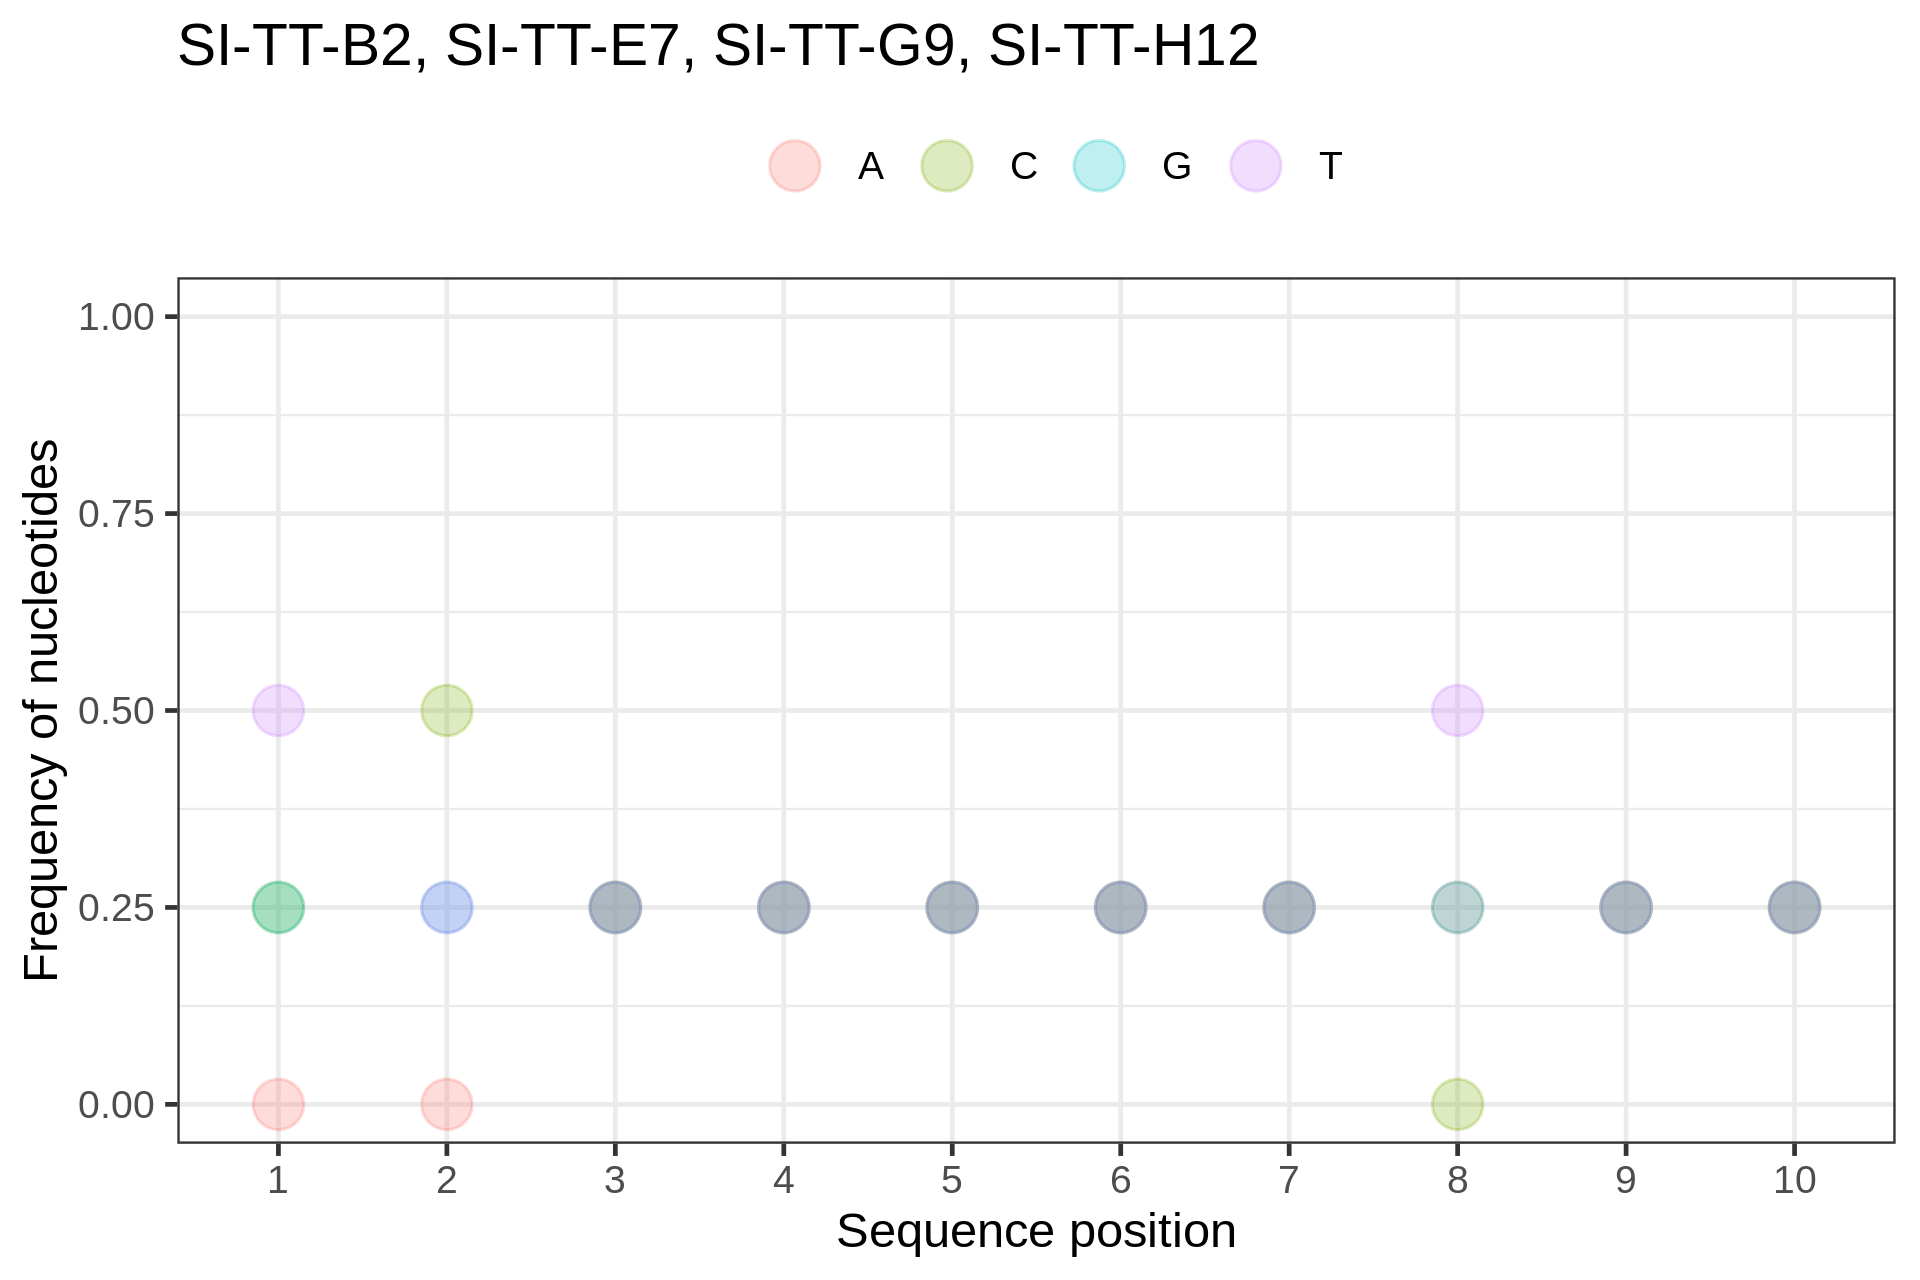

In [42]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 320)
plotfrequencies(seqA_df[1, ], sequences = seqA, len_seq = nts, pointsize = 5, n_seqs = 1)

# Two coupled sequences example

Now we use the same strategy but with matching pairs of sequences.

In [51]:
nts <- unique(nchar(indexes$index.i7.) + nchar(indexes$index2_workflow_a.i5.))
seqAB <- Biostrings::BStringSet(apply(indexes, 1, function(well) paste(well[-1], collapse = "") ))
names(seqAB) <- indexes$index_name
H_mat_seqAB <- as.matrix(Biostrings::stringDist(seqAB, method = "hamming",
                                                                              diag = TRUE, upper = TRUE))

In [52]:
result_seqAB <- mostdiverseindexes(distance_matrix = H_mat_seqAB, len_seq = nts, n_indexes = 4)
result_seqAB[[1]]

Warning message in FUN(X[[i]], ...):
“
Well 6: similar best score of 208 distance;
involved wells are SI-TT-A6, SI-TT-B3, SI-TT-E9, SI-TT-G3”
Warning message in FUN(X[[i]], ...):
“
Well 14: similar best score of 210 distance;
involved wells are SI-TT-B2, SI-TT-E8, SI-TT-F8, SI-TT-G5”
Warning message in FUN(X[[i]], ...):
“
Well 14: similar best score of 210 distance;
involved wells are SI-TT-B2, SI-TT-E10, SI-TT-G5, SI-TT-H12”
Warning message in FUN(X[[i]], ...):
“
Well 16: similar best score of 208 distance;
involved wells are SI-TT-B4, SI-TT-D1, SI-TT-E5, SI-TT-G10”
Warning message in FUN(X[[i]], ...):
“
Well 19: similar best score of 210 distance;
involved wells are SI-TT-B7, SI-TT-G1, SI-TT-G3, SI-TT-H3”
Warning message in FUN(X[[i]], ...):
“
Well 24: similar best score of 214 distance;
involved wells are SI-TT-B3, SI-TT-B7, SI-TT-B12, SI-TT-G3”
Warning message in FUN(X[[i]], ...):
“
Well 24: similar best score of 214 distance;
involved wells are SI-TT-B3, SI-TT-B7, SI-TT-B12, SI-TT

,SI-TT-A1,SI-TT-A2,SI-TT-A9,SI-TT-C1
SI-TT-A1,0,17,17,18
SI-TT-A2,17,0,17,19
SI-TT-A9,17,17,0,17
SI-TT-C1,18,19,17,0


In [53]:
viewranking(result_seqAB, len_seq = nts, n_indexes = 4)[[1]]

Maximum theoretical diversity is of 240



,SI-TT-E11,SI-TT-B11,SI-TT-E12,SI-TT-F1
SI-TT-E11,0,17,19,19
SI-TT-B11,17,0,17,18
SI-TT-E12,19,17,0,20
SI-TT-F1,19,18,20,0


In [54]:
seqAB_df <- getwells(result_seqAB, len_seq = nts, n_indexes = 4)
head(seqAB_df)

Maximum theoretical diversity is of 240



wells,diversity,well_1,well_2,well_3,well_4
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
"SI-TT-B11, SI-TT-E11, SI-TT-E12, SI-TT-F1",0.9166667,B11,E11,E12,F1
"SI-TT-B11, SI-TT-E11, SI-TT-E12, SI-TT-F1",0.9166667,B11,E11,E12,F1
"SI-TT-B1, SI-TT-D6, SI-TT-D9, SI-TT-E8",0.9000000,B1,D6,D9,E8
"SI-TT-B1, SI-TT-D6, SI-TT-D9, SI-TT-E8",0.9000000,B1,D6,D9,E8
"SI-TT-B1, SI-TT-D6, SI-TT-E8, SI-TT-E9",0.8916667,B1,D6,E8,E9
"SI-TT-B3, SI-TT-B7, SI-TT-B12, SI-TT-G3",0.8916667,B3,B7,B12,G3


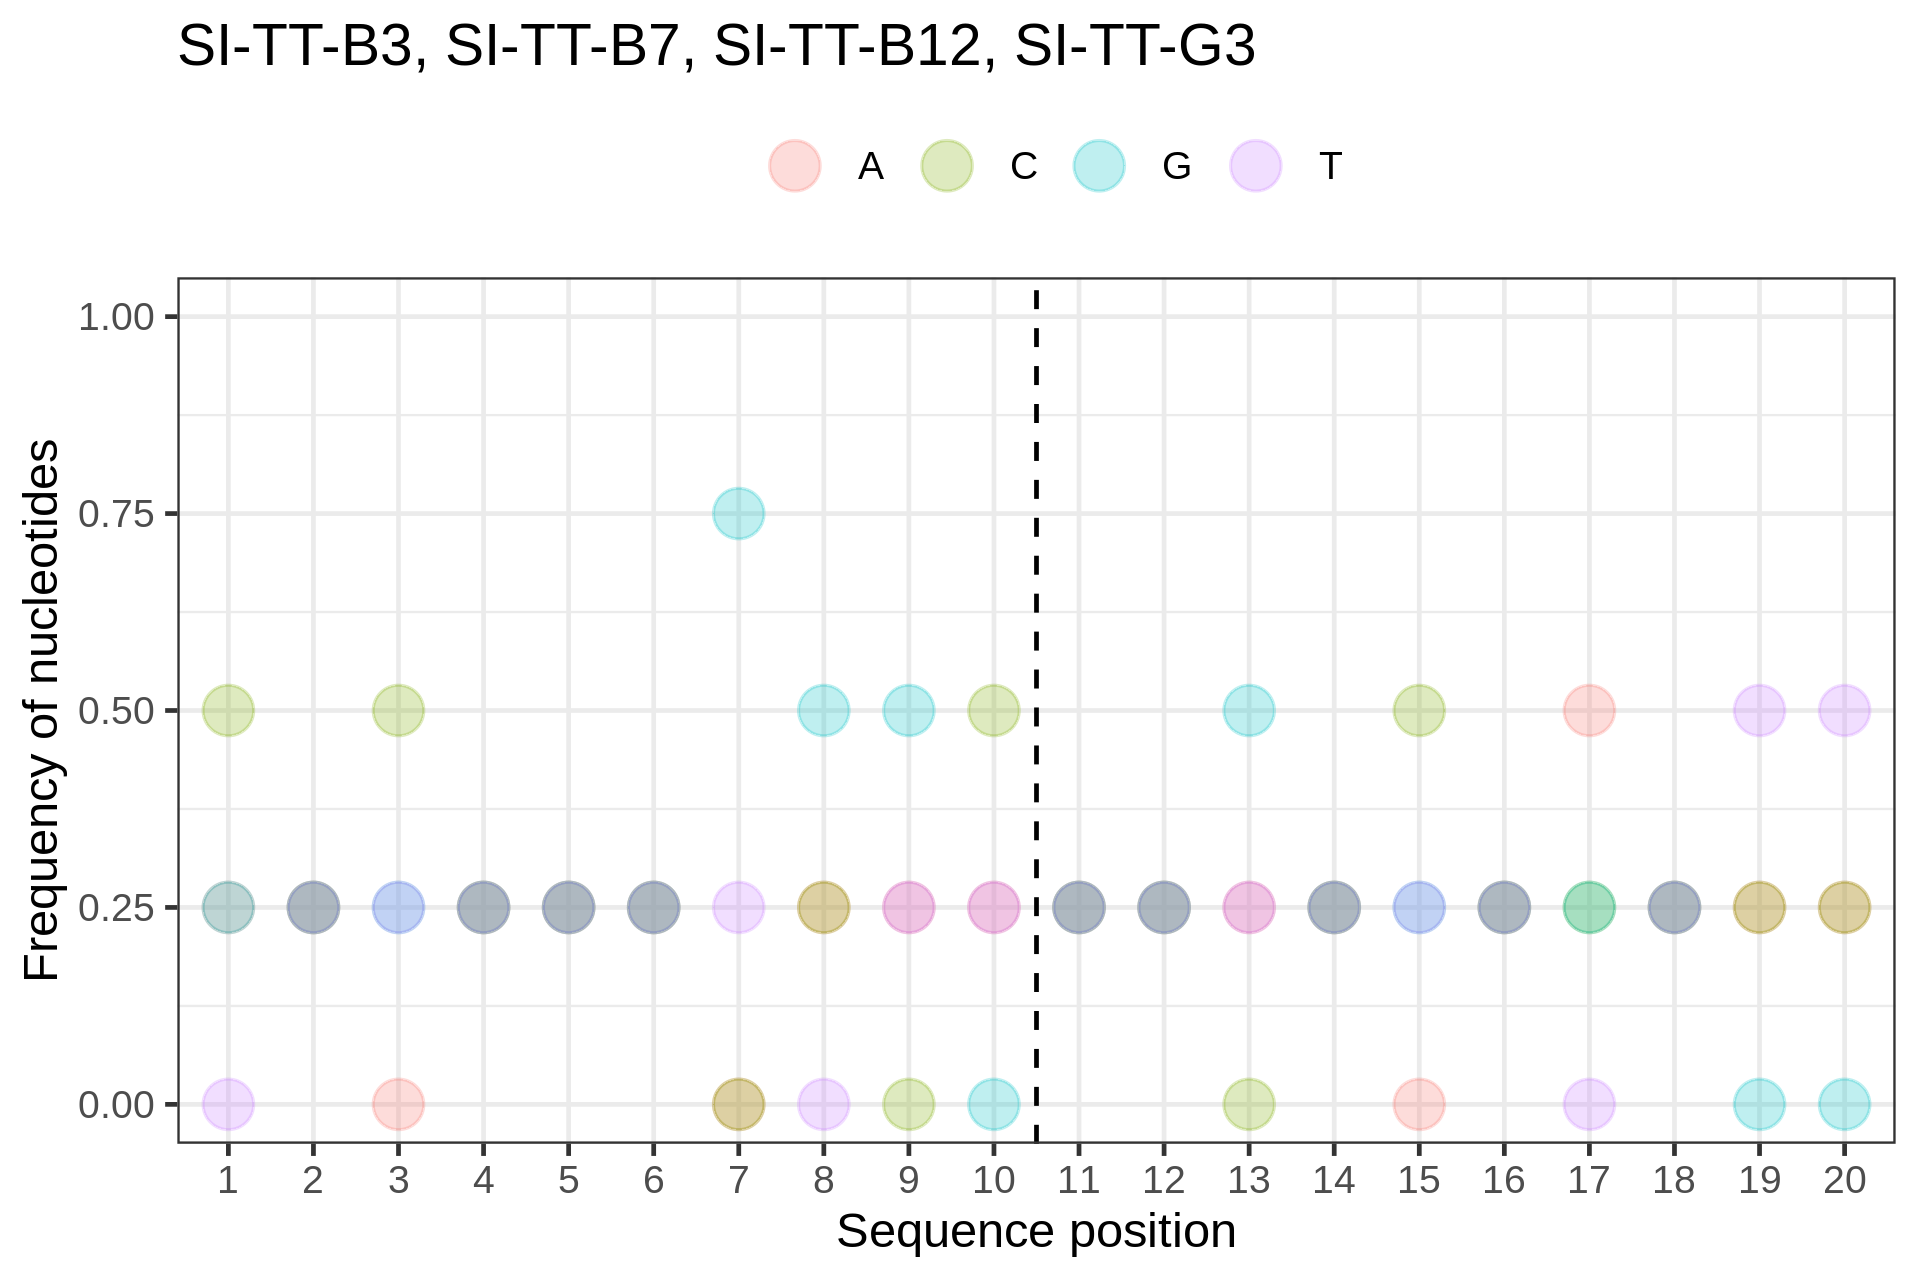

In [58]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 320)
plotfrequencies(seqAB_df[6, ], sequences = seqAB, len_seq = nts, pointsize = 5, n_seqs = 2)